In [36]:
import pandas as pd
from datapackage import Package
import matplotlib.pyplot as plt
import numpy as np
from iso3166 import countries
import plotly.io as pio
import math
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency
import os
import json
from api_keys import (puser, pkey)
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import scipy.stats as sts

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Country Code to Country Mapping (Helper Function)

In [37]:
package = Package('https://datahub.io/core/country-list/datapackage.json')

# print list of all resources:
#print(package.resource_names)

# print processed tabular data (if exists any)
for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        content = resource.read()
ISO_Alpha2_Country_Mapping = {item[1]:item[0] for item in content}
ISO_Alpha2_Country_Mapping['KR']='Korea' #From 'Korea, Republic of' to Korea

In [38]:
DF1 = pd.read_pickle("../Data/New_Video_DF_360217.pkl")
DF = pd.read_pickle("../Data/Cleaned_Data(No_Agg).pkl")

## NOTE
Our initial data set has 360217 trending videos (including multiple occuraces of some of the trending videos). However, only a subset of videos were returned through API call(266546 videos, including multiple occuraces of some of the trending videos). We are keeping only this subset for our feature studies as keeping the original set is sparse with multiple NaN values. Unless otherwise mentioned, the shorter(na removed) version of the data will be used for analysis. Please note that we have compared the analysis on both the Data wherever possible and they produce similar results 

In [39]:
DF1 = pd.read_pickle("../Data/New_Video_DF_360217.pkl")
DF = pd.read_pickle("../Data/Cleaned_Data(No_Agg).pkl")

Data_Lost = pd.DataFrame(DF1['country'].value_counts()).join(DF['viewing_country'].value_counts())
Data_Lost.columns=['Before', 'After']
Data_Lost['%Loss']=100*Data_Lost['After']/Data_Lost['Before']

Data_Lost

Data_Original = pd.DataFrame(100*Data_Lost['Before'].copy()/Data_Lost['Before'].sum())
Data_Original.columns=['% of occupation in data']
Data_Original['Total'] = Data_Lost['Before']

Data_Selected = pd.DataFrame(100*Data_Lost['After'].copy()/Data_Lost['After'].sum())
Data_Selected.columns=['% of occupation in data']
Data_Selected['Total'] = Data_Lost['After']

Before  After      %Loss
US   40859  36783  90.024230
CA   40834  32753  80.210119
DE   40812  30985  75.921298
FR   40690  29274  71.943967
RU   40101  28592  71.299968
MX   39857  24316  61.008104
GB   38663  33643  87.016010
IN   32252  24667  76.482079
KR   31715  17945  56.582059
JP   14434   7588  52.570320

# How Language affects Trending ?

**INSIGHTS**

* **As we would expect, The local language seems to play a big role in trending**
* **We studies the ratio of languages of trending videos across countries (English is Top3 for all except Russia, Japan and Korea)**
* **Only in Great Britain and United States, videos trend significantly more than other countries. Similarly,  English videos trend significantly more than other languages**

In [40]:
DF['Lang'].fillna('Unknown', inplace=True)

In [41]:
DF['Lang'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)


### Which Language Trended the most in which countries?

In [42]:
Country_Vs_Lang_Table = DF.groupby(['viewing_country', 'Lang'])['video_id'].count().unstack()
Country_Vs_Lang_Table = Country_Vs_Lang_Table.fillna(value=0).astype('int64')

In [43]:
def toppers(x, how_many=3):
    toppers = {key:x.to_dict()[key] for key in sorted(x.to_dict(), key=lambda y: x.to_dict()[y], reverse=True)[:how_many]}
    toppers.update({'Other':x.sum() - sum(toppers.values())})
    return toppers

Outer = Country_Vs_Lang_Table.sum(axis=1)

Inner = Country_Vs_Lang_Table.apply(lambda x:toppers(x,2), axis=1)   

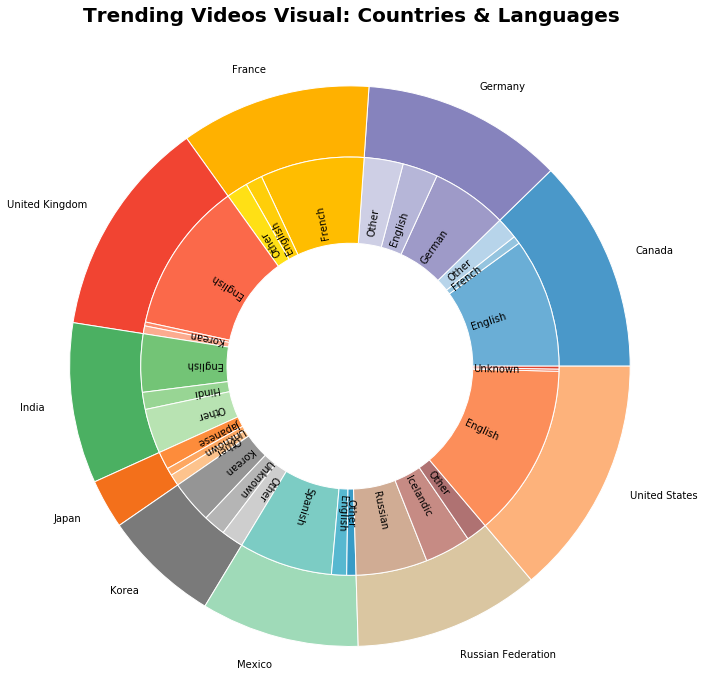

In [44]:
##Plot pie chart
fig, axis = plt.subplots(figsize = (10,10))
_=axis.axis('equal')
color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges , plt.cm.Greys, plt.cm.GnBu_r, plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

#Outer pie
labels = [ISO_Alpha2_Country_Mapping[cc] for cc in Outer.index]
pie1= axis.pie(Outer, labels=labels, colors=colors,radius=1.3)  
_=plt.setp(pie1[0], width=0.33, edgecolor='white' )

#Inner pie
names = list(np.array([list(item) for item in Inner.map(lambda x: x.keys()).to_list()]).flatten())
values = list(np.array([list(item) for item in Inner.map(lambda x: x.values()).to_list()]).flatten())
colors = []
for color in color_range:
    colors = colors + [color(i) for i in [0.5,0.4,0.3]]
pie2 = axis.pie(values, radius=1.3-.33, labels=names, labeldistance=0.7, colors=colors)
_=plt.setp(pie2[0], width=0.4, edgecolor='white')
_=plt.margins(0,0)

# do the rotation of the labels
for w, t in zip(pie2[0], pie2[1]):
    mang =(w.theta1 + w.theta2)/2.  # get mean_angle of the wedge
    #print(mang, t.get_rotation())
    _=t.set_rotation(mang)         # rotate the label by (mean_angle)
    _=t.set_va("center")
    _=t.set_ha("center")

#Tiding up the clutter
_=pie2[1][11].set_visible(False)
_=pie2[1][-1].set_visible(False)

_=plt.suptitle('Trending Videos Visual: Countries & Languages', fontsize=20, weight='bold', y=1)
_=plt.tight_layout()
_=axis.axis('equal')
#_= plt.savefig('../Image/Lang1.png', bbox_inches = "tight" )
_=plt.show()

# Is there any difference in popularity for trending (longevity) across countries ?

* **Only in Great Britain and United States, videos trend significantly more than other countries. Similarly,  English videos trend significantly more than other languages**

* Note:- Data used is the original version as there was no NaN's for the Viewing Countries

In [45]:
DF = DF1.groupby(['video_id', 'country'])['trending_date'].count().reset_index()
DF.columns = ['video_id','viewing_country','Total_Trend_Days']

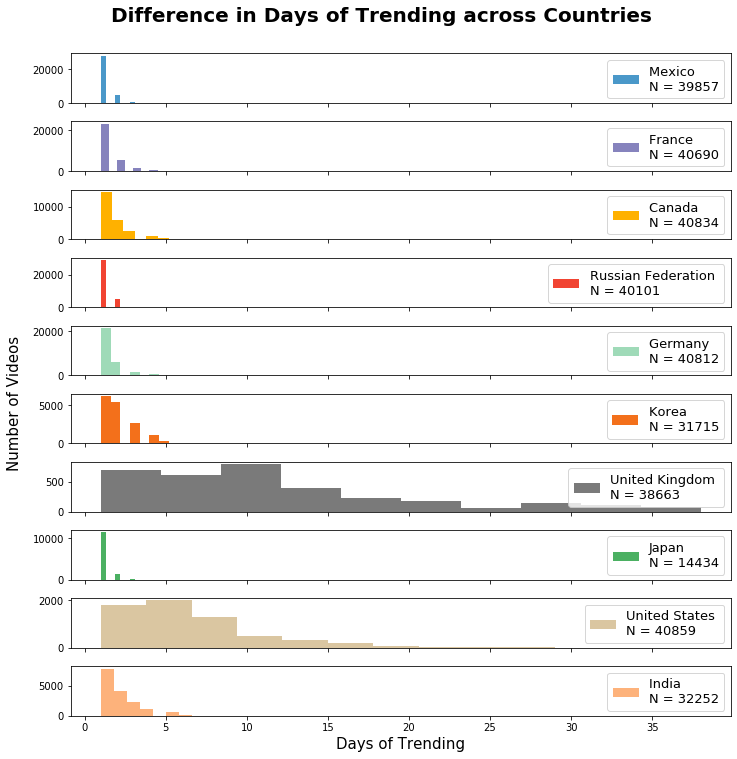

In [46]:
List_of_CCs = DF['viewing_country'].unique()

fig, axs = plt.subplots(10, 1, sharex=True, sharey=False, tight_layout=True, figsize=(10,10))

color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,cc in enumerate(List_of_CCs):
    _=axs[index].hist(DF[DF['viewing_country']==cc]['Total_Trend_Days'], color=colors[index], alpha=1, label=f"{ISO_Alpha2_Country_Mapping[cc]} \nN = {Data_Original.loc[cc, 'Total']}")

    #legend
    _=axs[index].legend(loc='upper right', fontsize = 13)
    

    
_=plt.suptitle('Difference in Days of Trending across Countries', fontsize=20, weight='bold', y=1.05) 
#xlabel, ylabel
_=plt.xlabel('Days of Trending',fontsize = 15)
_=fig.text(-0.02, 0.5, 'Number of Videos', va='center', rotation='vertical', fontsize = 15)


_ = plt.tight_layout()
#_= plt.savefig('../Image/Popularity_Across_Countries_with_360217.png', bbox_inches = "tight" )
plt.show()

# Is there any difference in popularity for trending (longevity) across languages ?

* **English videos trend significantly more than other languages**

In [47]:
DF = pd.read_pickle('../Data/Popularity_DF.pkl')

In [48]:
DF['Language'].fillna('Unknown', inplace=True)
DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)
Language_Count = pd.DataFrame(DF['Language'].value_counts())

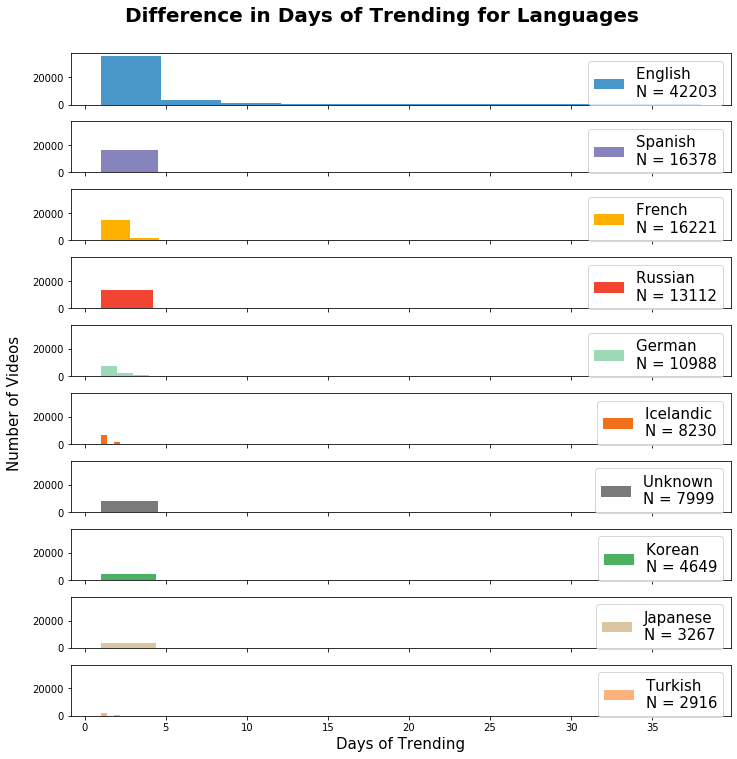

In [49]:
Top10 = Language_Count.index[:10]

fig, axs = plt.subplots(10, 1, sharex=True, sharey=True, tight_layout=True, figsize=(10,10))

color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,lang in enumerate(Top10):
    _=axs[index].hist(DF[DF['Language']==lang]['Total_Trend_Days'], color=colors[index], alpha=1, label=f"{lang} \nN = {Language_Count.loc[lang, 'Language']}")

    #legend
    _=axs[index].legend(loc='upper right', fontsize = 15)
    

    
_=plt.suptitle('Difference in Days of Trending for Languages', fontsize=20, weight='bold', y=1.05) 
#xlabel, ylabel
_=plt.xlabel('Days of Trending',fontsize = 15)
_=fig.text(-0.02, 0.5, 'Number of Videos', va='center', rotation='vertical', fontsize = 15)


_ = plt.tight_layout()
#_= plt.savefig('../Image/Popularity_for_Languages.png', bbox_inches = "tight" )
plt.show()

# How similar countries are in terms of their taste in trending videos ?

* We mapped countries into large dimensional vectors and measured cosine similarity (similar results with Jaccard similarity matrix too) between them to understand with countries watch the same content. It appears that all countries watch mostly distinct videos. However, if we see the most prominent relationships (highest match), results are astonishing!! When, we take only countries with at least 10% similarity, it shows Canada is similar to all other interconnected countries. This shows cross culture links in Canada (possibly Immigration)

* Note:- Data used is the original version as there was no NaN's for the Viewing Countries

In [50]:
DF = DF1.groupby(['video_id', 'country'])['trending_date'].count().reset_index()
DF.columns = ['video_id','viewing_country','Total_Trend_Days']

In [51]:
Country_Video_Table = DF.groupby('viewing_country').aggregate(Video_List = ('video_id', lambda x: x.to_list()))


In [52]:
Country_Video_Table.index = [ISO_Alpha2_Country_Mapping[cc] for cc in Country_Video_Table.index]
Country_Video_Table

Video_List
Canada              [--45ws7CEN0, --7vNbh4UNA, --MtKsH5oBY, --YgtV...
Germany             [--7vNbh4UNA, --I0aj8MUdU, --MtKsH5oBY, --moh3...
France              [--2K8l6BWfw, --728h8mnDY, --8-sr76Haw, --DqT_...
United Kingdom      [--uXQQ0h-yQ, -3VBPAZPTQI, -43MBOJnVks, -5WBCr...
India               [-0N9r10xb_0, -0WuM6ctLHg, -0mcgX4ro7I, -0neBE...
Japan               [-000V8w3RbI, -09XygZcXEU, -0Gd9DBh3W4, -0S2Gw...
Korea               [--97zv6Db3Q, -0Jw4AU9IKQ, -0SxwCD7Uc4, -0YMxu...
Mexico              [--1skHapGUc, --45ws7CEN0, --6vcer7XYQ, -01qCO...
Russian Federation  [--45ws7CEN0, --9LvCHDHYQ, -07PqRbugOM, -0Zl7W...
United States       [-0CMnp02rNY, -0NYY8cqdiQ, -1Hm41N0dUs, -1yT-K...

In [53]:
def Cosine_Similarity_Matrix(Table):
    N = Table.index.to_list()
    Sim_Matrix = pd.DataFrame(index=N, columns=N)
    for row in N:
        for col in N:
            Num = len(set(Table.loc[row][0]).intersection(set(Table.loc[col][0])))
            Denom = np.sqrt(len(Table.loc[row][0])*len(Table.loc[col][0]))
            Sim_Matrix.loc[row,col] = Num/Denom
    Sim_Matrix = Sim_Matrix.astype('float') 
    return Sim_Matrix

def Jaccard_Similarity_Matrix(Table):
    N = Table.index.to_list()
    Sim_Matrix = pd.DataFrame(index=N, columns=N)
    for row in N:
        for col in N:
            Num = len(set(Table.loc[row][0]).intersection(set(Table.loc[col][0])))
            Denom = len(set(Table.loc[row][0]).union(set(Table.loc[col][0])))
            Sim_Matrix.loc[row,col] = Num/Denom
    Sim_Matrix = Sim_Matrix.astype('float') 
    return Sim_Matrix
    

Canada   Germany    France  United Kingdom     India  \
Canada              1.000000  0.197145  0.153132        0.107190  0.072494   
Germany             0.197145  1.000000  0.133700        0.053791  0.036183   
France              0.153132  0.133700  1.000000        0.043843  0.041129   
United Kingdom      0.107190  0.053791  0.043843        1.000000  0.014116   
India               0.072494  0.036183  0.041129        0.014116  1.000000   
Japan               0.033306  0.021948  0.021304        0.014789  0.010274   
Korea               0.030298  0.017445  0.015537        0.019872  0.005722   
Mexico              0.061175  0.049535  0.045574        0.039297  0.016947   
Russian Federation  0.020505  0.062124  0.029110        0.017015  0.005754   
United States       0.181839  0.080388  0.046030        0.222950  0.022515   

                       Japan     Korea    Mexico  Russian Federation  \
Canada              0.033306  0.030298  0.061175            0.020505   
Germany             0.021948  0.017445  0.049535            0.062124   
France              0.021304  0.015537  0.045574            0.029110   
United Kingdom      0.014789  0.019872  0.039297            0.017015   
India               0.010274  0.005722  0.016947            0.005754   
Japan               1.000000  0.034611  0.015346            0.007943   
Korea               0.034611  1.000000  0.010892            0.006349   
Mexico              0.015346  0.010892  1.000000            0.013017   
Russian Federation  0.007943  0.006349  0.013017            1.000000   
United States       0.015141  0.014755  0.039921            0.013495   

                    United States  
Canada                   0.181839  
Germany                  0.080388  
France                   0.046030  
United Kingdom           0.222950  
India                    0.022515  
Japan                    0.015141  
Korea                    0.014755  
Mexico                   0.039921  
Russian Federation       0.013495  
United States            1.000000

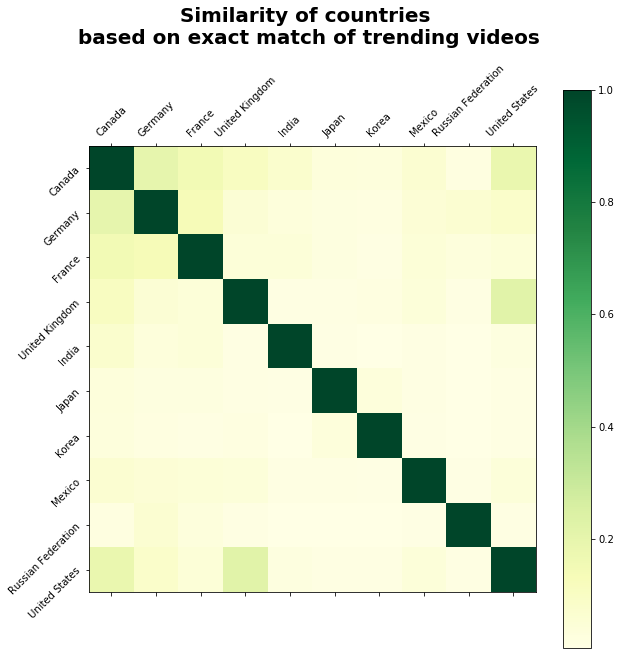

In [54]:
Similarity = Cosine_Similarity_Matrix(Country_Video_Table)
Similarity

_=plt.figure(figsize=(10,10))
_=plt.matshow(Similarity, fignum=1, cmap="YlGn")
_=plt.xticks(range(len(Similarity.columns)), Similarity.columns, rotation=45)
_=plt.yticks(range(len(Similarity.columns)), Similarity.columns, rotation=45)
_=plt.colorbar()
_=plt.suptitle('Similarity of countries\n based on exact match of trending videos', fontsize=20, weight='bold', x=0.45,y=0.98) 
#_= plt.savefig('../Image/Correlation_on_video_watch_with_360217.png')
_=plt.show()

Canada   Germany    France  United Kingdom     India  \
Canada              1.000000  0.108787  0.082350        0.035823  0.036830   
Germany             0.108787  1.000000  0.071630        0.016352  0.017620   
France              0.082350  0.071630  1.000000        0.013119  0.019981   
United Kingdom      0.035823  0.016352  0.013119        1.000000  0.005292   
India               0.036830  0.017620  0.019981        0.005292  1.000000   
Japan               0.016097  0.010194  0.009829        0.005973  0.005128   
Korea               0.015026  0.008383  0.007423        0.007535  0.002869   
Mexico              0.031149  0.025347  0.023293        0.011308  0.008017   
Russian Federation  0.010210  0.031970  0.014745        0.004819  0.002697   
United States       0.079434  0.031615  0.017676        0.118064  0.010215   

                       Japan     Korea    Mexico  Russian Federation  \
Canada              0.016097  0.015026  0.031149            0.010210   
Germany             0.010194  0.008383  0.025347            0.031970   
France              0.009829  0.007423  0.023293            0.014745   
United Kingdom      0.005973  0.007535  0.011308            0.004819   
India               0.005128  0.002869  0.008017            0.002697   
Japan               1.000000  0.017515  0.006924            0.003553   
Korea               0.017515  1.000000  0.005112            0.002961   
Mexico              0.006924  0.005112  1.000000            0.006551   
Russian Federation  0.003553  0.002961  0.006551            1.000000   
United States       0.007169  0.006711  0.014826            0.004924   

                    United States  
Canada                   0.079434  
Germany                  0.031615  
France                   0.017676  
United Kingdom           0.118064  
India                    0.010215  
Japan                    0.007169  
Korea                    0.006711  
Mexico                   0.014826  
Russian Federation       0.004924  
United States            1.000000

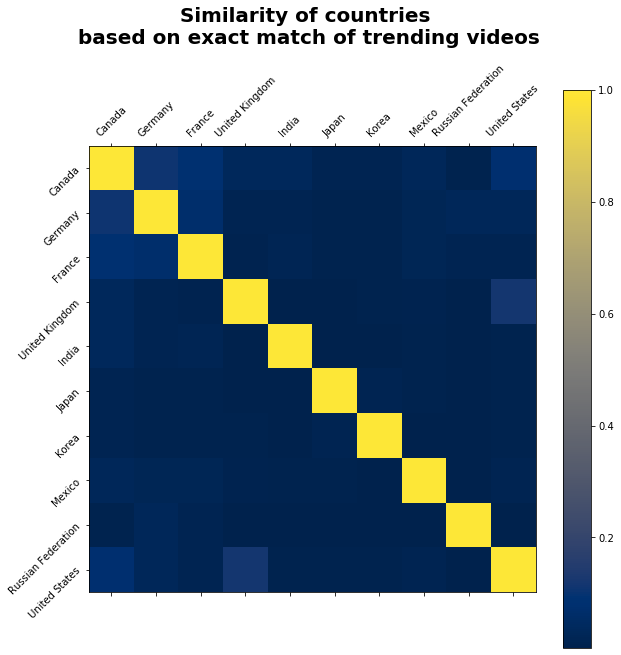

In [55]:
Similarity2 = Jaccard_Similarity_Matrix(Country_Video_Table)
Similarity2

_=plt.figure(figsize=(10,10))
_=plt.matshow(Similarity2, fignum=1, cmap='cividis')
_=plt.xticks(range(len(Similarity2.columns)), Similarity.columns, rotation=45)
_=plt.yticks(range(len(Similarity2.columns)), Similarity.columns, rotation=45)
_=plt.colorbar()
_=plt.suptitle('Similarity of countries\n based on exact match of trending videos', fontsize=20, weight='bold', x=0.45,y=0.98) 
#_= plt.savefig('../Image/Correlation_on_video_watch_with_360217.png')
_=plt.show()

In [56]:
Country_ISO_Dict = {val:key for key,val in ISO_Alpha2_Country_Mapping.items()}
Country_similarity = dict()
for i,j in zip(*np.where(Similarity>=0.1)):
    if (i!=j):
        Country_similarity[Country_ISO_Dict[Similarity.index[i]]]=Country_similarity.get(Country_ISO_Dict[Similarity.index[i]], [])+[Country_ISO_Dict[Similarity.index[j]]]
        
Country_similarity #Will be used later for censorship analysis 

{'CA': ['DE', 'FR', 'GB', 'US'],
 'DE': ['CA', 'FR'],
 'FR': ['CA', 'DE'],
 'GB': ['CA', 'US'],
 'US': ['CA', 'GB']}

In [57]:
Sorted_Similarity = Similarity.stack().sort_values(ascending=False)

In [58]:
Morethan10perc = Sorted_Similarity[Sorted_Similarity!=1][Sorted_Similarity[Sorted_Similarity!=1]>=0.1].reset_index()

In [59]:
Morethan10perc.reset_index(inplace=True)
Morethan10perc.columns = ['index', 'countries', 'relationship', 'similarity']

In [60]:
Morethan10perc['relationship'] = Morethan10perc.apply(lambda x: "Relationship: {}".format(x['index']//2 + 1), axis=1)

In [61]:
Morethan10perc['iso_code'] = Morethan10perc['countries'].map(Country_ISO_Dict)
Morethan10perc['iso_code_alpha3'] = Morethan10perc['iso_code'].map(lambda x: [item for item in countries.get(x)][2])
Country_RelationShip_Dict = Morethan10perc.groupby('countries').aggregate(relationships =  ('relationship', lambda x: '\n'.join(x.to_list()))).to_dict()['relationships']   
Morethan10perc['relationships'] = Morethan10perc['countries'].map(lambda x: "{}: {}".format(x, Country_RelationShip_Dict[x]))


In [62]:
import plotly.express as px

fig = px.line_geo(Morethan10perc, hover_name= 'relationships',locations="iso_code_alpha3",
                  color="relationship",
                  projection="equirectangular")

#pio.write_html(fig, file='../Image/Conuntry_Similarity_based_on_what_is_trending_with_360217.html', auto_open=False)
#'equirectangular', 'orthographic'

fig.show()

In [63]:
#Pushing the plot to plotly
#import chart_studio as cs
#cs.tools.set_credentials_file(username=puser, api_key=pkey)
#cs.tools.set_config_file(world_readable=True,
#                             sharing='public')

#cs.plotly.plot(fig, filename = 'Conuntry_Similarity_based_on_what_is_trending', auto_open=True)

# What categories are trended in which coutries? Is there a similarity?

* **We studied trending categories across countries and found "Entertainment" is the most trending category in all countries except Great Britain(GB) and Russia. In GB, Music outnumbered the Entertainment whereas in Russia "People & Blogs" surmounted Entertainment!** 

* **We clustered countries based on the how much they watch in each categories. The clustering method we chose is hierarchical clustering as we have only 10 countries to compare**
 - **Cluster1 - Canada, Germany, France, India, Japan and Mexico  - Significantly high interest in Entertainment compared to all other categories**
 - **Cluster2 - Korea & Russia - Along with Entertainment, they also have interest in News & Politics and People & Blogs**
 - **Cluster3 - UK & US - Common interest in Music & Entertainment**
 
* Note:- Data used is the original version as there was no NaN's for the Viewing Countries and Categories.

In [64]:
#Cleanup on the original DF
DF1 = pd.read_pickle("../Data/New_Video_DF_360217.pkl")
DF1.rename(columns={'country':'viewing_country'}, inplace=True)

List_of_JSON = [(file, file.split('_')[0]) for file in list(os.walk(os.path.join('..', 'Data')))[0][-1] if (file.endswith("category_id.json"))]   
Dict_Catogory = dict()
file = 'US_category_id.json'
with open(os.path.join('..', 'Data', file)) as f:
    data = json.load(f)
    Dict_Catogory.update({int(item['id']): item['snippet']['title'] for item in data['items']})
#Dict_Catogory

DF1['Category'] = DF1['category_id'].map(Dict_Catogory)
DF1.drop('category_id', axis=1, inplace=True)

DF = DF1.copy()

In [65]:
Country_Vs_Cat_Table = DF.groupby(['viewing_country', 'Category'])['video_id'].count().unstack()
Country_Vs_Cat_Table = Country_Vs_Cat_Table.fillna(value=0).astype('int64')

In [66]:
def toppers(x, how_many=3):
    toppers = {key:x.to_dict()[key] for key in sorted(x.to_dict(), key=lambda y: x.to_dict()[y], reverse=True)[:how_many]}
    toppers.update({'Other':x.sum() - sum(toppers.values())})
    return toppers

Outer = Country_Vs_Cat_Table.sum(axis=1)

Inner = Country_Vs_Cat_Table.apply(lambda x:toppers(x,4), axis=1)   

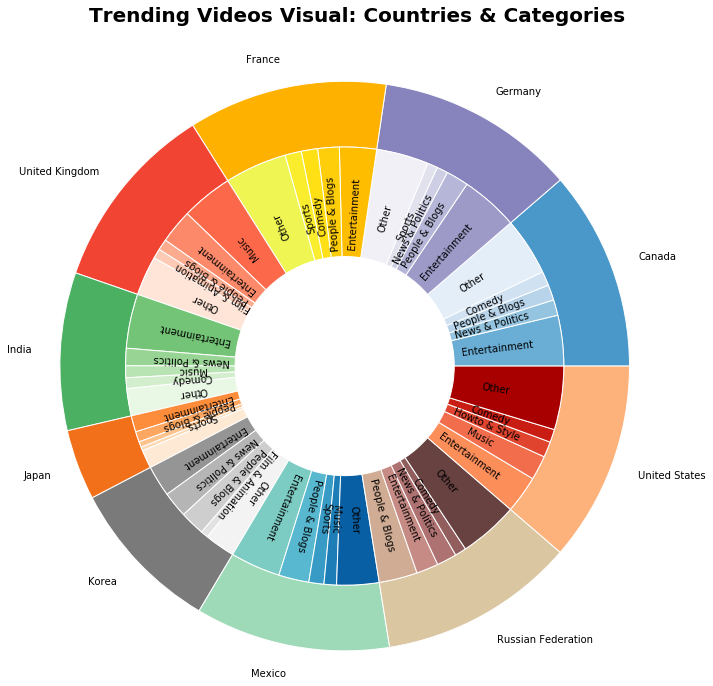

In [67]:
fig, axis = plt.subplots(figsize = (10,10))
_=axis.axis('equal')
color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges , plt.cm.Greys, plt.cm.GnBu_r, plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

#Outer pie
labels = [ISO_Alpha2_Country_Mapping[cc] for cc in Outer.index]
pie1= axis.pie(Outer, labels=labels, colors=colors,radius=1.3)  
_=plt.setp(pie1[0], width=0.3, edgecolor='white' )

#Inner pie
names = list(np.array([list(item) for item in Inner.map(lambda x: x.keys()).to_list()]).flatten())
values = list(np.array([list(item) for item in Inner.map(lambda x: x.values()).to_list()]).flatten())
colors = []
for color in color_range:
    colors = colors + [color(i) for i in [0.5,0.4,0.3,0.2,0.1]]
pie2 = axis.pie(values, radius=1.3-0.3, labels=names, labeldistance=0.7, colors=colors)
_=plt.setp(pie2[0], width=0.5, edgecolor='white')
_=plt.margins(0,0)

# do the rotation of the labels
for w, t in zip(pie2[0], pie2[1]):
    mang =(w.theta1 + w.theta2)/2.  # get mean_angle of the wedge
    #print(mang, t.get_rotation())
    _=t.set_rotation(mang)         # rotate the label by mean_angle
    _=t.set_va("center")
    _=t.set_ha("center")
    _=t.set
#Tiding up the clutter
#_=pie2[1][27].set_visible(False)
_=pie2[1][28].set_visible(False)
_=pie2[1][29].set_visible(False)


_=plt.suptitle('Trending Videos Visual: Countries & Categories', fontsize=20, weight='bold', y=1)

_=plt.tight_layout()
#_= plt.savefig('../Image/Cat1_with_360217.png', bbox_inches = "tight" )
_=plt.show()

# Clustering of Countries based on the categories

In [68]:
from sklearn.preprocessing import normalize
#It normalize each sample (Row wise)
scaled_country = normalize(Country_Vs_Cat_Table)
scaled_country = pd.DataFrame(scaled_country, columns=Country_Vs_Cat_Table.columns, index=Country_Vs_Cat_Table.index)

array([0, 0, 0, 1, 0, 0, 2, 0, 2, 1])

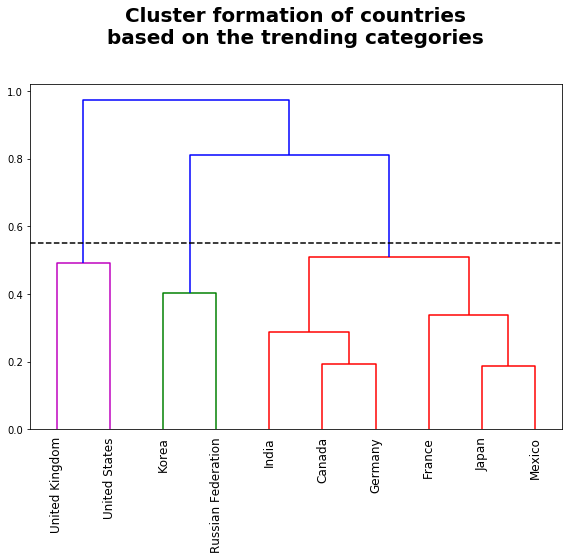

Category         Autos & Vehicles    Comedy  Education  Entertainment  \
viewing_country                                                         
CA                       0.021693  0.232403   0.061074       0.828108   
DE                       0.049505  0.143696   0.047861       0.866653   
FR                       0.046338  0.299406   0.052958       0.676525   
GB                       0.008323  0.105131   0.026413       0.520570   
IN                       0.004301  0.178835   0.071496       0.898786   
JP                       0.039165  0.084597   0.015144       0.754235   
KR                       0.008772  0.141502   0.034861       0.629781   
MX                       0.014574  0.100724   0.030852       0.780583   
RU                       0.109599  0.210719   0.049123       0.409665   
US                       0.026726  0.240326   0.115117       0.691469   

Category         Film & Animation    Gaming  Howto & Style    Movies  \
viewing_country                                                        
CA                       0.126278  0.082829       0.123628  0.000370   
DE                       0.134282  0.088690       0.098954  0.000113   
FR                       0.148255  0.100469       0.162805  0.000759   
GB                       0.147554  0.102762       0.111431  0.000000   
IN                       0.088264  0.003241       0.049368  0.000623   
JP                       0.146913  0.121499       0.098522  0.000000   
KR                       0.151114  0.096115       0.039590  0.000000   
MX                       0.075044  0.057414       0.143212  0.000000   
RU                       0.209037  0.071828       0.138260  0.000070   
US                       0.162166  0.056793       0.288280  0.000000   

Category            Music  News & Politics  Nonprofits & Activism  \
viewing_country                                                     
CA               0.229876         0.255945               0.004314   
DE               0.134509         0.166152               0.014517   
FR               0.271962         0.258446               0.007792   
GB               0.790536         0.070396               0.005202   
IN               0.195540         0.287918               0.006420   
JP               0.156661         0.174416               0.002263   
KR               0.128458         0.522377               0.020215   
MX               0.194690         0.180645               0.014691   
RU               0.130832         0.373155               0.106305   
US               0.450099         0.172954               0.003967   

Category         People & Blogs  Pets & Animals  Science & Technology  \
viewing_country                                                         
CA                     0.252740        0.022741              0.071058   
DE                     0.339392        0.014233              0.045592   
FR                     0.394013        0.016274              0.055234   
GB                     0.168938        0.030805              0.029823   
IN                     0.145050        0.000125              0.031603   
JP                     0.482690        0.143606              0.018277   
KR                     0.501247        0.051566              0.007781   
MX                     0.472123        0.004878              0.030617   
RU                     0.714847        0.041906              0.077714   
US                     0.223275        0.064031              0.165855   

Category            Shows    Sports  Trailers  Travel & Events  
viewing_country                                                 
CA               0.007642  0.171698  0.000000         0.024159  
DE               0.006068  0.156058  0.000057         0.007996  
FR               0.006827  0.299406  0.000138         0.008206  
GB               0.001156  0.109986  0.000000         0.005548  
IN               0.009101  0.039208  0.000000         0.000499  
JP               0.000000  0.258839  0.000000         0.015666  
KR               0.011824  0.066

In [69]:
import scipy.cluster.hierarchy as shc

_=plt.figure(figsize=(8, 8))  
_=plt.title("Cluster formation of countries\nbased on the trending categories", fontsize=20, weight='bold', y=1.1)

shc.set_link_color_palette(['m','g','r'])
dend = shc.dendrogram(shc.linkage(scaled_country, method='ward'), )
_=plt.axhline(y=0.55, color='k', linestyle='--')
_=plt.xticks(plt.xticks()[0], [ISO_Alpha2_Country_Mapping[scaled_country.index[id]] for id in dend['leaves']], rotation=90)

from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(scaled_country)

_=plt.tight_layout()
#_= plt.savefig('../Image/Country_cluster_based_on_categories_with_360217.png', bbox_inches = "tight" )
_=plt.show()

scaled_country

In [70]:
Country_Cluster = pd.DataFrame(Country_Vs_Cat_Table.reset_index()['viewing_country'])
Country_Cluster['Country'] = Country_Cluster['viewing_country'].map(ISO_Alpha2_Country_Mapping)
Country_Cluster['iso_code_alpha3'] = Country_Cluster['viewing_country'].map(lambda x: [item for item in countries.get(x)][2])

Country_Cluster['Cluster'] = cluster.fit_predict(scaled_country)


In [71]:
import plotly.express as px

fig = px.choropleth(Country_Cluster, locations="iso_code_alpha3",
                    color="Cluster",
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale='sunset') #px.colors.sequential.Plasma
fig.show()

#pio.write_html(fig, file='../Image/Country_Clusters_based_on_what_categories_are_trending_with_360217.html', auto_open=False)

In [72]:
#Pushing the plot to plotly
#cs.plotly.plot(fig, filename = 'Country_Clusters_based_on_what_categories_are_trending', auto_open=True)

# Is there any difference in popularity (longevity) across categories ?

**We define popularity(longevity) as the number the days of trending**
- **Almost all categories have a varying popularity**
- **However, it looks like "Non-profit & Activism" tend to have relatively shorter limelight**
- **Note that "Trailers" are only 2 in the dataset. Hence, it is not enough evidence to say that, they trend less

Note:- Data used is the cleaned(shorter) version as we would be using the shorter version for model building as it is devoid of NaNs for a wide variety of features. Hence, we need to analyse the factors affecting popularity with the same Data

In [73]:
DF = pd.read_pickle('../Data/Popularity_DF.pkl')

DF['Language'].fillna('Unknown', inplace=True)
DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)

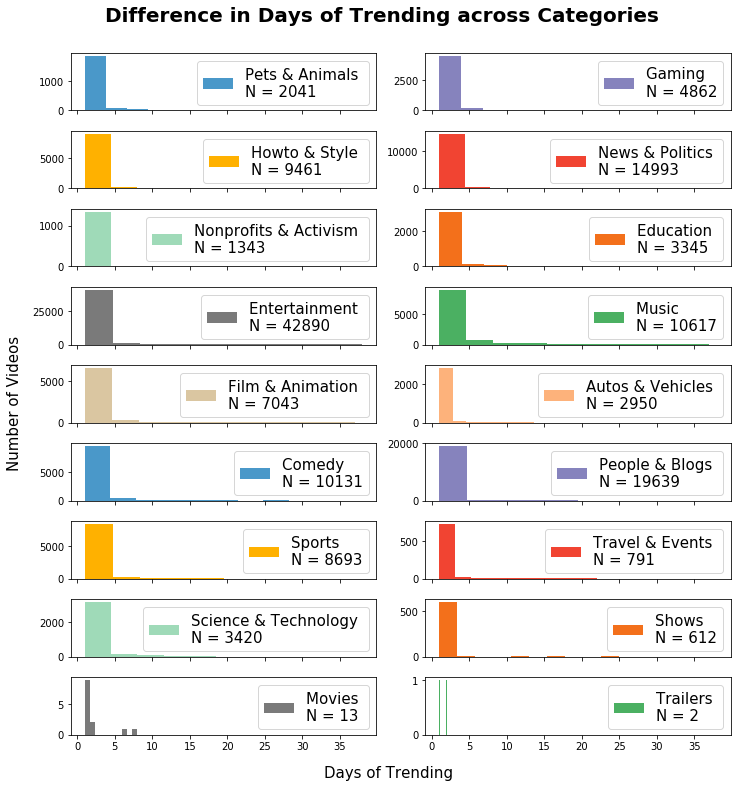

In [74]:
List_of_Cats = DF['Category'].unique()
Category_Count = pd.DataFrame(DF['Category'].value_counts())

fig, axs = plt.subplots(9, 2, sharex=True, sharey=False, tight_layout=True, figsize=(10,10))
axs = axs.ravel()
color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,cat in enumerate(List_of_Cats):
    _=axs[index].hist(DF[DF['Category']==cat]['Total_Trend_Days'], color=colors[index%10], alpha=1, label=f"{cat} \nN = {Category_Count.loc[cat, 'Category']}")

    #legend
    _=axs[index].legend(loc='upper right', fontsize = 15)
    

    
_=plt.suptitle('Difference in Days of Trending across Categories', fontsize=20, weight='bold', y=1.05) 
#xlabel, ylabel
_=fig.text(-0.02, 0.5, 'Number of Videos', va='center', rotation='vertical', fontsize = 15)
_=fig.text(0.51, -0.02, 'Days of Trending', ha='center', rotation='horizontal', fontsize = 15)


_ = plt.tight_layout()
#_= plt.savefig('../Image/Popularity_Across_Categories.png', bbox_inches = "tight" )
plt.show()

In [75]:
DF.groupby('Category')['Total_Trend_Days'].describe()

count      mean       std  min   25%  50%   75%   max
Category                                                                      
Autos & Vehicles        2950.0  1.330508  1.030026  1.0  1.00  1.0  1.00  19.0
Comedy                 10131.0  2.084000  2.181306  1.0  1.00  1.0  2.00  35.0
Education               3345.0  1.868161  2.241602  1.0  1.00  1.0  2.00  31.0
Entertainment          42890.0  1.788296  2.132509  1.0  1.00  1.0  2.00  38.0
Film & Animation        7043.0  2.037058  2.820366  1.0  1.00  1.0  2.00  37.0
Gaming                  4862.0  1.885438  2.381924  1.0  1.00  1.0  2.00  30.0
Howto & Style           9461.0  1.758799  2.364859  1.0  1.00  1.0  2.00  36.0
Movies                    13.0  2.076923  2.253203  1.0  1.00  1.0  2.00   8.0
Music                  10617.0  3.303664  5.080521  1.0  1.00  2.0  3.00  37.0
News & Politics        14993.0  1.568599  1.416798  1.0  1.00  1.0  2.00  35.0
Nonprofits & Activism   1343.0  1.352941  1.321807  1.0  1.00  1.0  1.00  36.0
People & Blogs         19639.0  1.571210  1.756691  1.0  1.00  1.0  2.00  38.0
Pets & Animals          2041.0  1.867222  2.621089  1.0  1.00  1.0  2.00  29.0
Science & Technology    3420.0  2.048538  2.513604  1.0  1.00  1.0  2.00  36.0
Shows                    612.0  1.312092  1.325435  1.0  1.00  1.0  1.00  25.0
Sports                  8693.0  1.611296  1.928114  1.0  1.00  1.0  2.00  38.0
Trailers                   2.0  1.500000  0.707107  1.0  1.25  1.5  1.75   2.0
Travel & Events          791.0  1.872314  2.167103  1.0  1.00  1.0  2.00  22.0

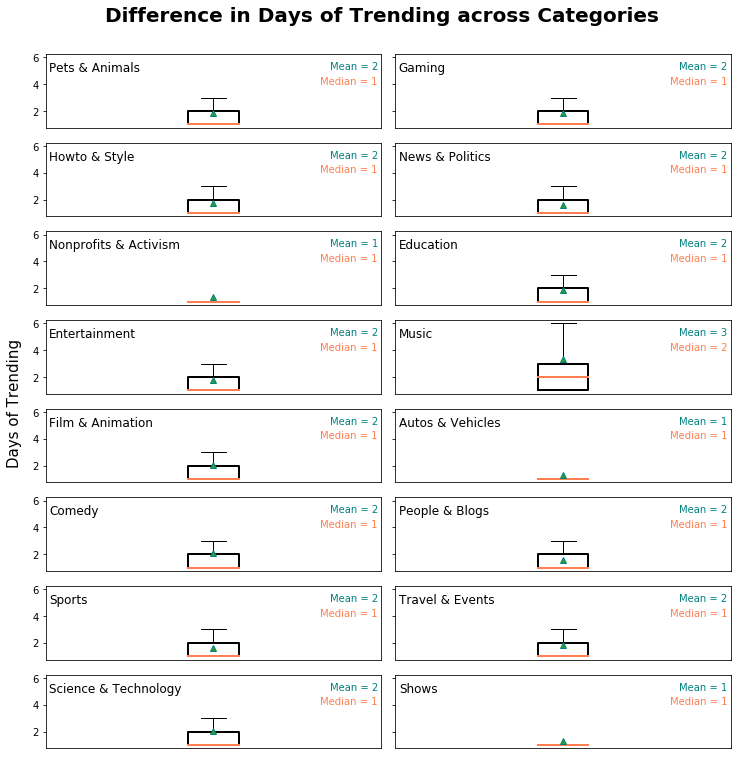

In [76]:
#Box plot to convey the same effectively!
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=2, color='coral')
meanprops = dict(markeredgecolor='teal')
fig, axs = plt.subplots(8, 2, sharex=True, sharey=True, tight_layout=True, figsize=(10,10))
axs = axs.ravel()

color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,cat in enumerate(List_of_Cats[:-2]):
    Dict = axs[index].boxplot(DF[DF['Category']==cat]['Total_Trend_Days'], 
                                      showfliers=False,
                                      showmeans=True,
                                      boxprops=boxprops,
                                      medianprops=medianprops,
                                      meanprops=meanprops)
    #_=axs[index].legend([cat], loc='upper right', fontsize = 10)
    _=axs[index].text(0.01,0.9, cat,
                     fontsize=12,
                     horizontalalignment='left',
                     verticalalignment='top',
                     transform = axs[index].transAxes)
   
    _=axs[index].set_xticklabels([])
    _=axs[index].set_xticks([])
    
    #Annotate
        
    for line in Dict['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # top of median line
        # overlay median value
        _=axs[index].text(0.99,0.7, "Median = {:.0f}".format(y),
             horizontalalignment='right',
                          verticalalignment='top',
                          color='coral',
                         transform = axs[index].transAxes)

    for line in Dict['means']:
        # get position data for median line

        x, y = line.get_xydata()[0] # top of median line
        # overlay mean value
        _=axs[index].text(0.99, 0.9, "Mean = {:.0f}".format(y),
             horizontalalignment='right',
                        verticalalignment='top',
                        color='teal',
                       transform = axs[index].transAxes)

_=plt.suptitle('Difference in Days of Trending across Categories', fontsize=20, weight='bold', y=1.05) 

#xlabel, ylabel
_=fig.text(-0.02, 0.5, 'Days of Trending', va='center', rotation='vertical', fontsize = 15)


_ = plt.tight_layout()
#_= plt.savefig('../Image/Popularity_Across_Categories_box_plot.png', bbox_inches = "tight" )

plt.show()

# Feature Selection of Categorical Variables

**We used statistical measures to understand the prominent features (attributes) that affects popularity (No. of days of trending)**
- **Since the number of days of trending(popularity), we cannot treat this problem as a regression problem and use statistical methods. Hence, we have categorized the popularity into 4 ranges**
 - 1Day Trending -> 'JustTrending'
 - 1 to 5 Days Trending-> 'Popular'
 - 5 to 14 Days Trending -> 'UlraPopular'
 - \>14 Days Trending -> 'Phenomenon'
- **Used Chi-squared Feature Selection for categorical features**
- **Use ANOVA test for numeric features**
**Please note that this study is a preliminary one and doesn't identify the combined effects of attributes on output**


## Chi-Squared / ANOVA Feature Selection function

In [77]:
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

# prepare input data
def encode(X):
    oe = OrdinalEncoder()
    oe.fit(X) 
    return oe


def feature_selection(DF, function, ravel=False):
    
    columns = DF.columns
    #Create separate encoders for input and output
    encoder_X = encode(DF[columns[:-1]])
    X = encoder_X.transform(DF[columns[:-1]])

    encoder_Y = encode(DF['Popularity_Category'].to_numpy().reshape(-1,1))
    Y = encoder_Y.transform(DF['Popularity_Category'].to_numpy().reshape(-1,1))
    if ravel:
        Y=Y.ravel()
    fs = SelectKBest(score_func=function, k='all')
    fs.fit(X, Y)
    
    # what are scores for the features
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i, fs.scores_[i]))
    # plot the scores
    fig, ax = plt.subplots(figsize=(8,6))
    _=plt.bar([i for i in range(len(fs.scores_))], fs.scores_, color='teal', width=0.6)
    _=plt.xticks([i for i in range(len(fs.scores_))], columns[:-1], rotation=90)
    _=plt.ylabel('Significance Score', fontsize=12)

    a,b=(('categorical', 'chi-square') if function==chi2 else ('numeric', 'ANOVA'))
    label = "Feature importance of {} variables \n using {} test".format(a,b)
    _=plt.title(label, fontsize=15, weight='bold', y=1.01)
    _=plt.tight_layout()
    #_= plt.savefig('../Image/Feature_Selection_of_{}variables.png'.format(a), bbox_inches = "tight" )
    plt.show()
    
    return fs.scores_, fs.pvalues_


In [78]:
def Basic_Cleanup():
    DF = pd.read_pickle('../Data/Popularity_DF.pkl')

    #Language fill NaN and cleanup
    DF['Language'].fillna('Unknown', inplace=True)
    DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)

    Country_Category_Popularity_DF = DF[['viewing_country', 'Category', 'Origin_Country', 'Language', 'Comments_Disabled', 'Ratings_Disabled', 'Blocked', 'Allowed', 'GoogleAnalyticsUsed', 'IsmoderatingComments', 'Total_Trend_Days']].copy()

    #import missingno as msno
    #_=msno.matrix(Country_Category_Popularity_DF)
    #Origin_Country fill NaN and cleanup
    Country_Category_Popularity_DF['Origin_Country'].fillna(value='Not_Disclosed', inplace=True)
    return Country_Category_Popularity_DF


def map_to_cat(x):
    #np.quantile(Country_Category_Popularity_DF['Total_Trend_Days'], [0.95, 0.999])
    #1 -> 'JustTrending'
    #(1 to 5] -> 'Popular' #5 is 95th %
    #(5 to 14] -> 'UlraPopular' #14 is 99.1%
    #>14 -> 'Phenomenon'
    return ('JustTrending' if x==1 else ('Popular' if x<=5 else ('UltraPopular' if x<=14 else "Phenomenon")))

Feature 0: 9136.199843
Feature 1: 1763.807408
Feature 2: 26352.847353
Feature 3: 49299.231133
Feature 4: 126.115758
Feature 5: 91.221857
Feature 6: 133.616390
Feature 7: 72.862969
Feature 8: 121.805762


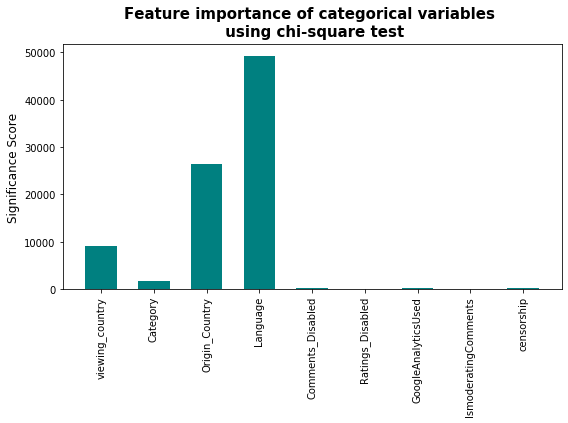

(array([ 9136.19984317,  1763.80740809, 26352.84735332, 49299.23113338,
          126.11575757,    91.22185733,   133.61638978,    72.86296909,
          121.80576155]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.71569028e-27, 1.19701563e-19, 8.98781502e-29, 1.04002336e-15,
        3.15145775e-26]))

In [79]:
#Retrieve Country_Category_Popularity_DF after basic cleanup
Country_Category_Popularity_DF = Basic_Cleanup()
#Derive a new variable censorship if any blocking
Country_Category_Popularity_DF['censorship'] = Country_Category_Popularity_DF.apply(lambda x: (False if ((x['Blocked']!=x['Blocked']) and (x['Allowed']!=x['Allowed'])) else True),axis=1)
Country_Category_Popularity_DF['Popularity_Category'] = Country_Category_Popularity_DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      
Country_Category_Popularity_DF.drop(['Blocked', 'Allowed', 'Total_Trend_Days'], inplace=True, axis=1)

feature_selection(Country_Category_Popularity_DF, chi2)
#_=msno.matrix(Country_Category_Popularity_DF)

## Feature Selection of Numeric Variables  (ANOVA Test)

Feature 0: 200.768561
Feature 1: 406.064902
Feature 2: 5835.287534
Feature 3: 5480.808362
Feature 4: 2524.251736
Feature 5: 3911.372618
Feature 6: 1015.285355


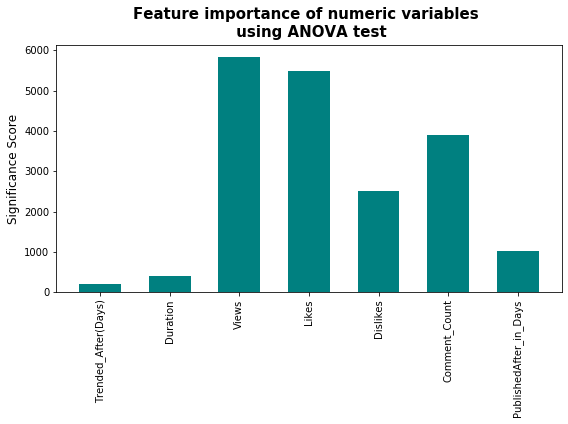

(array([ 200.76856128,  406.06490198, 5835.28753387, 5480.80836217,
        2524.25173613, 3911.37261773, 1015.28535524]),
 array([5.99249756e-130, 1.08968772e-262, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000]))

In [80]:
def indays(x,y):
    z=x.date()-y.date()
    return z.days
def Basic_Cleanup_Numeric():
    DF = pd.read_pickle('../Data/Popularity_DF.pkl')

    DF['Trended_After(Days)'] = DF.apply(lambda x: indays(x['First_Trending'],x['Publish_Time']), axis=1)

    Country_Category_Popularity_DF = DF[['viewing_country', 'Trended_After(Days)','Duration', 'Views', 'Likes', 'Dislikes', 'Comment_Count', 'PublishedAfter_in_Days', 'Blocked', 'Allowed', 'Total_Trend_Days']].copy()
    
    
    Country_Category_Popularity_DF['Popularity_Category'] = Country_Category_Popularity_DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      
    Country_Category_Popularity_DF.drop(['viewing_country', 'Blocked', 'Allowed', 'Total_Trend_Days'], inplace=True, axis=1)

    return Country_Category_Popularity_DF


#Retrieve Country_Category_Popularity_DF after basic cleanup
Country_Category_Popularity_DF = Basic_Cleanup_Numeric()

feature_selection(Country_Category_Popularity_DF, function=f_classif, ravel=True)
#_=msno.matrix(Country_Category_Popularity_DF)

# Study on Boolean Categorical Variables

* **Based on the feature selection study, it appears that Boolean Categorical variables are less significant than others**

* **In this section, we study if they are any significant at all**

In [81]:
Country_Category_Popularity_DF = DF[['viewing_country', 'Category', 'Origin_Country', 'Language', 'Comments_Disabled', 'Ratings_Disabled', 'Blocked', 'Allowed', 'GoogleAnalyticsUsed', 'IsmoderatingComments', 'Total_Trend_Days']].copy()
Country_Category_Popularity_DF['Popularity_Category'] = Country_Category_Popularity_DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      

def plot_popularity_distribution(col, text, filename, legend=None, title=None):
    #col:- Column name in Country_Category_Popularity_DF you want to analyse the significance for
    #text:- text in the graph
    #filename:- filename to save
    #legend:- legend names as a list
    
    contingency_table=Country_Category_Popularity_DF.groupby(col)['Popularity_Category'].value_counts().unstack()
    
    stat, p, dof, expected = chi2_contingency(contingency_table)


    # interpret p-value
    alpha = 0.01
    if p <= alpha:
        print(f'Popularity depends on {col} (reject H0)')
    else:
        print(f'Popularity is independent of {col} (fail to reject H0)')
    
    DF=pd.DataFrame(Country_Category_Popularity_DF.groupby(col)['Popularity_Category'].value_counts(normalize=True))
    DF.columns = ['Percentage']
    DF = DF.unstack(level=0)
    DF = DF.loc[['JustTrending', 'Popular', 'UltraPopular', 'Phenomenon'],:]
    DF['Percentage']=DF['Percentage']*100

    DF.columns.name = col
    if legend==None:
        DF.columns = [col[1] for col in DF.columns]
    else:
        DF.columns = legend
        
    yTicks = np.arange(0, (DF.max().max()//10)*10 + 11, 10)
    ax = DF.plot.bar(rot=0, figsize=(6,4), color=['teal', 'blue'], width=0.6)

    #Beautification !!!
    suptitle = (f'Popularity Distribution\n with and without {col.capitalize()}' if title==None else title)
    _=plt.suptitle(suptitle, fontsize=16, weight='bold', y=1.08)
    _=plt.yticks(yTicks, [f"{val}%" for val in yTicks])

    #xlabel, ylabel
    _=plt.xlabel('Popularity Category',fontsize = 14)
    _=plt.ylabel('Percentage',fontsize = 14)

    #legend
    _=plt.legend(loc='upper right', fontsize = 12)
    text = "{}\np-value = {:.1f}".format(text, p)
    bbox_props = dict(boxstyle="round", fc="lightcoral", ec="grey", lw=2, alpha=0.3)
    t = ax.text(0.6, 0.6, text, ha="center", va="center",
            size=10, transform=ax.transAxes,
            bbox=bbox_props)

    _ =plt.tight_layout()
    ax.get_figure().savefig(f'../Image/{filename}',bbox_inches = "tight" )

## Censorship

Popularity depends on censorship (reject H0)


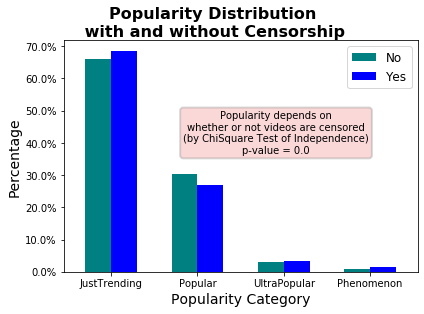

In [82]:
Country_Category_Popularity_DF['censorship'] = Country_Category_Popularity_DF.apply(lambda x: (False if ((x['Blocked']!=x['Blocked']) and (x['Allowed']!=x['Allowed'])) else True),axis=1)
plot_popularity_distribution('censorship', "Popularity depends on\nwhether or not videos are censored\n(by ChiSquare Test of Independence)", 'Effect_of_Censorship_on_popularity.png', legend=["No", "Yes"])


## Study on Comment Moderation

Popularity depends on IsmoderatingComments (reject H0)


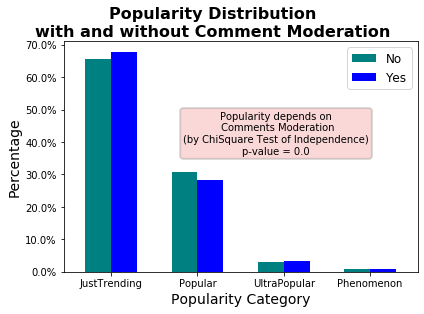

In [83]:
plot_popularity_distribution('IsmoderatingComments', "Popularity depends on\n Comments Moderation\n(by ChiSquare Test of Independence)", 'Effect_of_Comment_Moderation_on_popularity.png', legend=["No", "Yes"], title="Popularity Distribution\nwith and without Comment Moderation" )



## Study on Google Analytics

Popularity depends on GoogleAnalyticsUsed (reject H0)


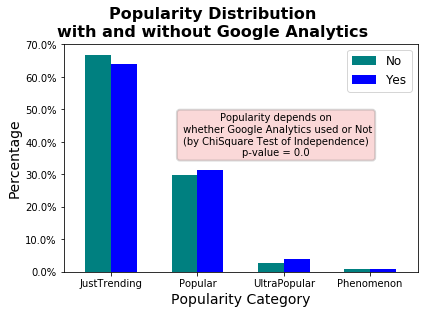

In [84]:
plot_popularity_distribution('GoogleAnalyticsUsed', "Popularity depends on\n whether Google Analytics used or Not\n(by ChiSquare Test of Independence)", 'Effect_of_Google_Analytics_on_popularity.png', legend=["No", "Yes"], title="Popularity Distribution\nwith and without Google Analytics" )


## Study on Ratings Disabled

Popularity depends on Ratings_Disabled (reject H0)


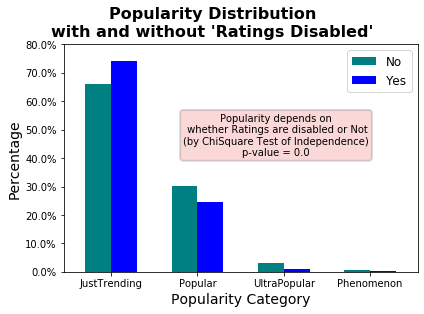

In [85]:
plot_popularity_distribution('Ratings_Disabled', "Popularity depends on\n whether Ratings are disabled or Not\n(by ChiSquare Test of Independence)" , 'Effect_of_Ratings_Disabled_on_popularity.png',legend=["No", "Yes"], title="Popularity Distribution\nwith and without 'Ratings Disabled'")    



## Study on Comments Disabled

Popularity depends on Comments_Disabled (reject H0)


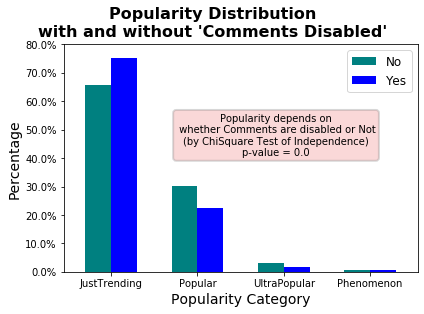

In [86]:
plot_popularity_distribution('Comments_Disabled', "Popularity depends on\n whether Comments are disabled or Not\n(by ChiSquare Test of Independence)", 'Effect_of_Ratings_disabled_or_Not_on_popularity.png', legend=["No", "Yes"], title="Popularity Distribution\nwith and without 'Comments Disabled'" )
